<a href="https://colab.research.google.com/github/rufimelo99/UltimatumGame/blob/main/UltimatumGame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classes

## Player Class

In [51]:
import random
import numpy as np
import numpy.random as rnd
import math

class Player:
    def __init__(self, id, Neigbours) -> None:
        self.id=id
        self.bargainValues=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
        self.mapValuesIndex = {0: 0, 0.1: 1, 0.2: 2, 0.3: 3, 0.4:4, 0.5: 5, 0.6: 6, 0.7: 7, 0.8: 8, 0.9: 9, 1: 1}
        self.mapIndexValues = {0: 0, 1: 0.1, 2: 0.2, 3: 0.3, 4:0.4, 5: 0.5, 6: 0.6, 7: 0.7, 8: 0.8, 9: 0.9, 1: 1}
        self.neighbours = []
        self.AvgComulativePayoff = 0
        self.qinitProposer = np.zeros((len(self.bargainValues), 1))
        self.qinitCorrespondent = np.zeros((len(self.bargainValues), 2))
        self.ComulativePayoff = 0
        
        """
                #payoff per bargain value-> either accept or not
      Qinit   = [0  0
                0   3
                5   0
                .
                .
                .        ]
        """        

    def qlearningIterationAsProposer(self, bargainAccepted, bargainIndexOnTable):
        #bargainAccepted: 0 or 1 which also works as position in the qinit
        
        self.qinitProposer[bargainIndexOnTable] += 0.3*(self.bargainValues[bargainIndexOnTable]*bargainAccepted + 0.9 * np.max(self.qinitProposer[:,0]) - self.qinitProposer[bargainIndexOnTable])

    def qlearningIterationAsCorrespondent(self, bargainAccepted, bargainIndexOnTable):
        #bargainAccepted: 0 or 1 which also works as position in the qinit
        
        action = bargainAccepted
        
        self.qinitCorrespondent[bargainIndexOnTable][action] += 0.3*(self.bargainValues[bargainIndexOnTable]*bargainAccepted + 0.9 * np.max(self.qinitCorrespondent[:,1]) - self.qinitCorrespondent[bargainIndexOnTable][action])

    def makeOffer(self):
        #returns index of bargain proposal 
        #offer from Proposer

        #yes or no
        bargainValueIndexRandom = rnd.choice(len(self.bargainValues))
        bargainValueIndex = rnd.choice(np.where(self.qinitProposer[:,0] == np.max(self.qinitProposer[:,0]))[0])     #offer what is best for himself according to its policy
        
        
        index = rnd.choice([bargainValueIndexRandom, bargainValueIndex], p = [0.15, 0.85])

        
        #print("\nPlayer " + str(self.id) +" made offer of: "+str(self.bargainValues[index]))
        return index

    def bargainDecision(self, bargainValueIndex):
        #print("Proposer reward in question: "+str(self.bargainValues[bargainValueIndex]))
        #print("Correspondent reward in question: "+str(self.bargainValues[-(bargainValueIndex+1)]))
        
        correspondentValueIndex = self.bargainValues.index(self.bargainValues[-(bargainValueIndex+1)])
        #print("Correspondent index: "+str(correspondentValueIndex))

        #yes or no
        
        aux = rnd.choice(2)     #len of options        
        aux1 = rnd.choice(np.where(self.qinitCorrespondent[correspondentValueIndex] == np.max(self.qinitCorrespondent[correspondentValueIndex]))[0])    #most profitable choice
        

        index = rnd.choice([aux, aux1], p = [0.15, 0.85])

        return index, correspondentValueIndex

        



## Ultimaum Game Class

In [52]:
import networkx as nx
import matplotlib.pyplot as plt

class ultimatumGame:
    def __init__(self, Nplayers) -> None:
        #Erdos-Renyi
        self.graph = nx.erdos_renyi_graph(Nplayers, 0.15)
        self.Players = {}
        #create all players
        for i in range(Nplayers):
            player = Player(i, list(self.graph.adj[i]))
            player.neighbours = list(self.graph.adj[i])
            self.Players[i]=player

    def printGraph(self):
        #nx.draw_shell(self.graph, with_labels = True)
        #nx.draw(self.graph, with_labels = True)
        
        fig = plt.figure(figsize=(40, 40)) 
        nx.draw(self.graph, node_size=70) 
        plt.axis('equal') 
        plt.show() 
        plt.show()

    

# Execution

## Game Creation


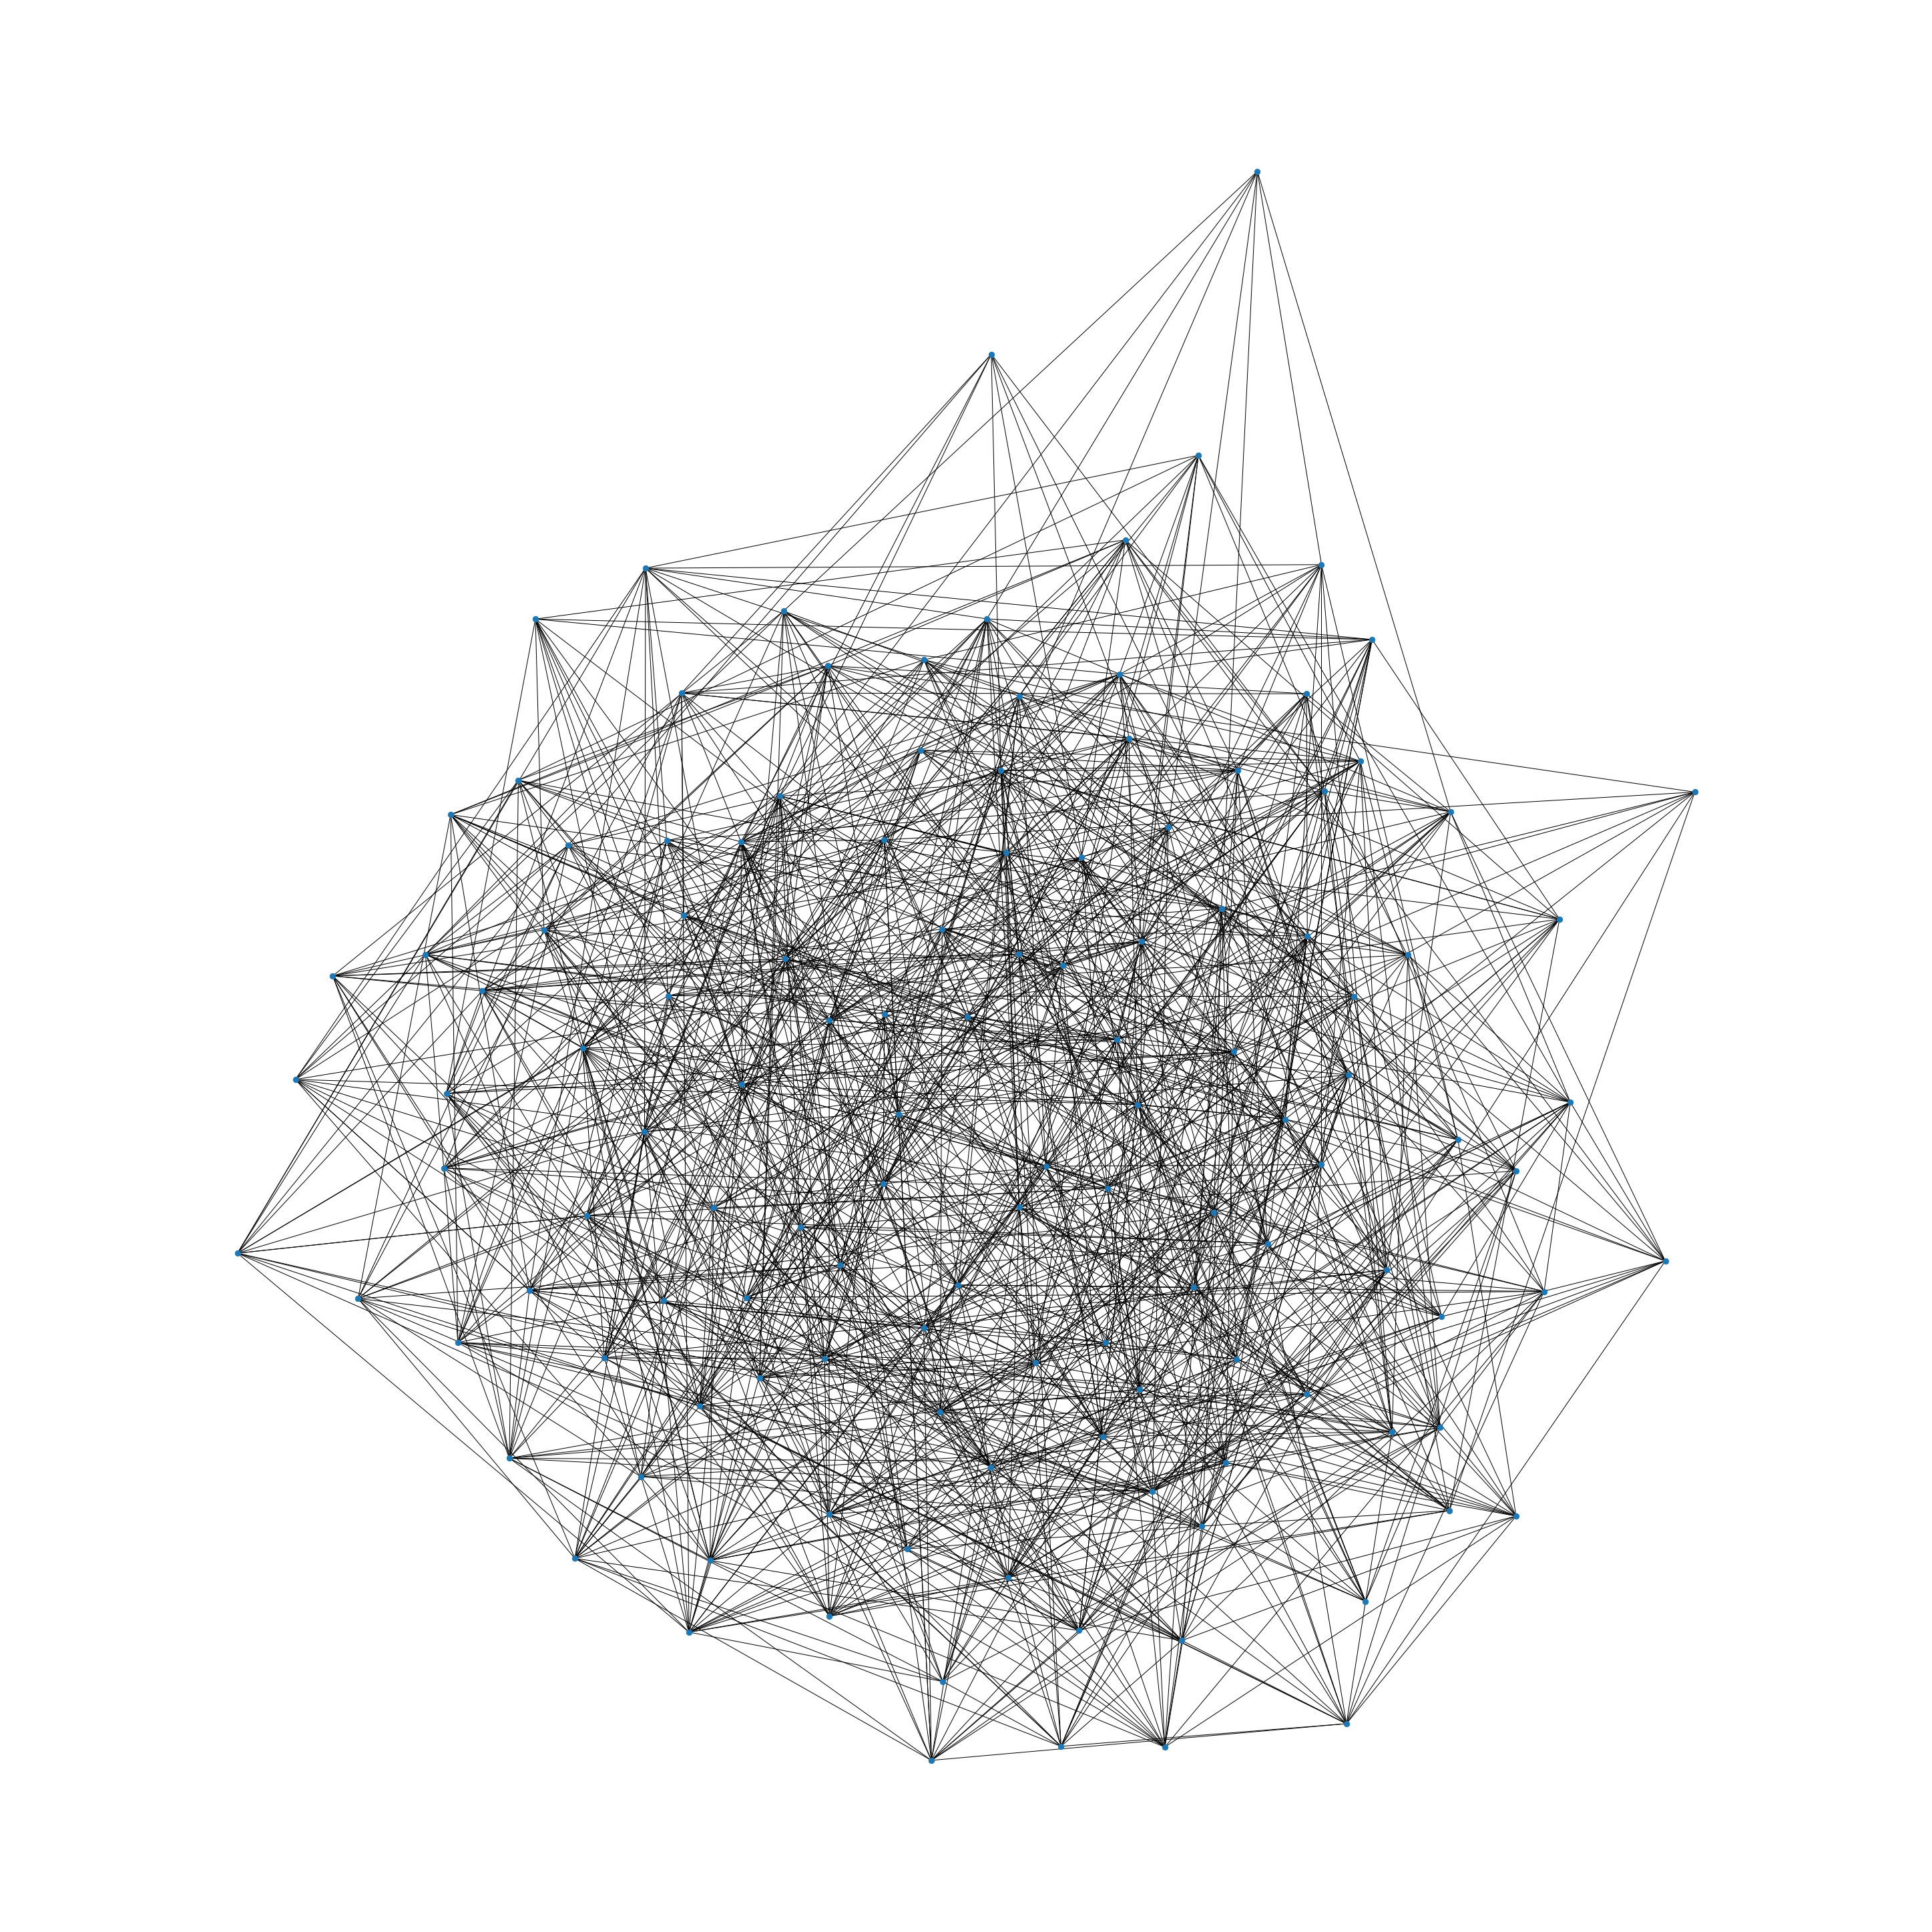

In [53]:
NPLAYERS = 128

game = ultimatumGame(NPLAYERS)

game.printGraph()




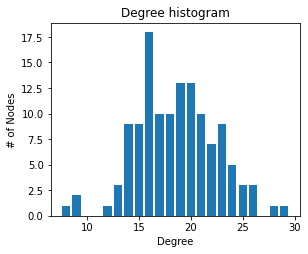

In [54]:
degree_sequence = sorted([d for n, d in game.graph.degree()], reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
axgrid = fig.add_gridspec(5, 4)

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

## Running Game

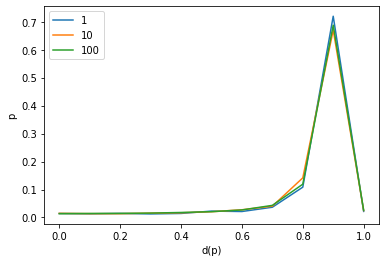

In [56]:
NITERATIONS = 101

offersDicInitial={0:0, 0.1:0, 0.2:0, 0.3:0, 0.4:0, 0.5:0, 0.6:0, 0.7:0, 0.8:0, 0.9:0, 1:0}
offerDic = {}
stopsForGraphs = [1,10,100,1000,10000]


for i in range(NITERATIONS):
  for playerId in range(len(game.Players)):
    for neighbourId in game.Players[playerId].neighbours:
      player = game.Players[playerId]
      neighbour = game.Players[neighbourId]
      #print(player.qinit)
      playerBargainIndex=player.makeOffer()
      rewardAcceptedOrNot, neighbourBargainIndex = neighbour.bargainDecision(playerBargainIndex)
      player.qlearningIterationAsProposer(rewardAcceptedOrNot, playerBargainIndex)
      neighbour.qlearningIterationAsCorrespondent(rewardAcceptedOrNot, neighbourBargainIndex)

      #add payoffs to player
      player.ComulativePayoff+=rewardAcceptedOrNot*player.bargainValues[playerBargainIndex]
      neighbour.ComulativePayoff+=rewardAcceptedOrNot*neighbour.bargainValues[neighbourBargainIndex]

       
      offersDicInitial[player.bargainValues[playerBargainIndex]]+=1
      
  #save data for graphs
  if i in stopsForGraphs:
    offerDic[i]=offersDicInitial.copy()
    offersDicInitial.update({}.fromkeys(offersDicInitial,0))
  
  #get the comulative payoffs after a round-robin round
  lowerPayoff = 1.0
  lowerPayoffId = 0
  for playerId in range(len(game.Players)):
    player = game.Players[playerId]
    player.AvgComulativePayoff = player.ComulativePayoff/(len(player.neighbours)*2)
    #reseting payoffs of that round
    player.ComulativePayoff=0
    #updating lowerPayoff if necessary
    if player.AvgComulativePayoff<lowerPayoff:
      lowerPayoff=player.AvgComulativePayoff
      lowerPayoffId=player.id

  
  #Social penalty
  #question here-> should the policy be updated to some random present in the graph or a fresh one?
  playerToBeRemoved = game.Players[lowerPayoffId]
  #handle its neighbours
  for i in playerToBeRemoved.neighbours:
    newPlayerBehaviourId = rnd.choice(len(game.Players))
    #update its qtable
    game.Players[i].qinitProposer = game.Players[lowerPayoffId].qinitProposer
    game.Players[i].qinitCorrespondent = game.Players[lowerPayoffId].qinitCorrespondent

  #handle the player with the worst payoff
  newPlayerBehaviourId = rnd.choice(len(game.Players))
  #update its qtable
  playerToBeRemoved.qinitProposer = game.Players[lowerPayoffId].qinitProposer  
  playerToBeRemoved.qinitCorrespondent = game.Players[lowerPayoffId].qinitCorrespondent  

plt.plot([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], np.array(list(offerDic[1].values())) /sum(np.array(list(offerDic[1].values()))) , label = "1" ) 
plt.plot([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], np.array(list(offerDic[10].values()))/sum(np.array(list(offerDic[10].values()))), label = "10")
plt.plot([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], np.array(list(offerDic[100].values()))/sum(np.array(list(offerDic[100].values()))), label = "100")
#plt.plot([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], np.array(list(offerDic[1000].values()))/sum(np.array(list(offerDic[1000].values()))), label = "1000")
#plt.plot([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], np.array(list(offerDic[10000].values()))/sum(np.array(list(offerDic[10000].values()))), label = "10000")


# naming the x axis
plt.xlabel('d(p)')
# naming the y axis
plt.ylabel('p')
# show a legend on the plot
plt.legend()
plt.show()

In [ ]:
for playerId in range(len(game.Players)):
  player = game.Players[playerId]
  print(player.qinit)
  print("qinit")